# Mary shuttlebox tracking

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline

# load libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("OpenCV version: {}".format(cv2.__version__))

OpenCV version: 3.2.0


In [4]:
# load in the video

cap = cv2.VideoCapture("shuttle_box_lightbluefeltwithfish.mp4")

# print some stats about the video

width, height = cap.get(3), cap.get(4)
number_frames = int(cap.get(7))
fps = cap.get(5)

print("""
size of video: {w} x {h}
total number of frames: {num}
fps: {fps}
""".format(w = width, h = height, num = number_frames, fps = fps))


size of video: 960.0 x 544.0
total number of frames: 38057
fps: 62.5



(544, 960, 3)


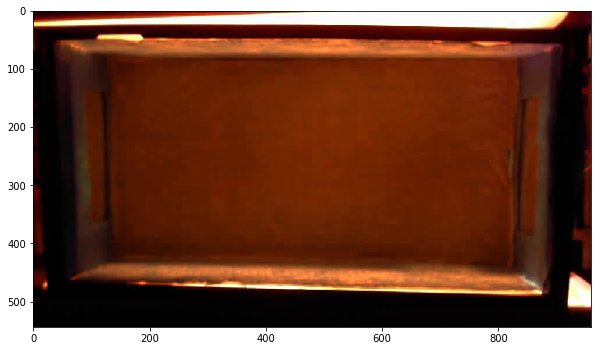

In [5]:
# show the first image
_, frame = cap.read()

print(frame.shape)

plt.figure(figsize = (10,10))
plt.imshow(frame)
plt.show()

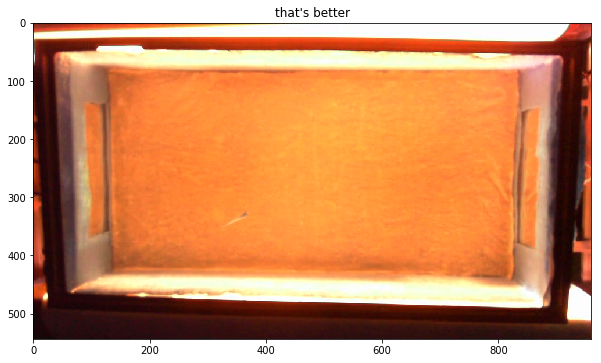

In [6]:
# Mary told me to skip ahead many frames:

cap.set(1, 2000)
ret, frame = cap.read()

# plot it
plt.figure(figsize = (10,10))
plt.imshow(frame)
plt.title("that's better")
plt.show()

Let's try calculating the background then using background subtraction to find where the fish is.

1
1269
2537
3805
5073
6341
7609
8877
10145
11413
12681
13949
15217
16485
17753
19021
20289
21557
22825
24093
25361
26629
27897
29165
30433
31701
32969
34237
35505
36773
38041


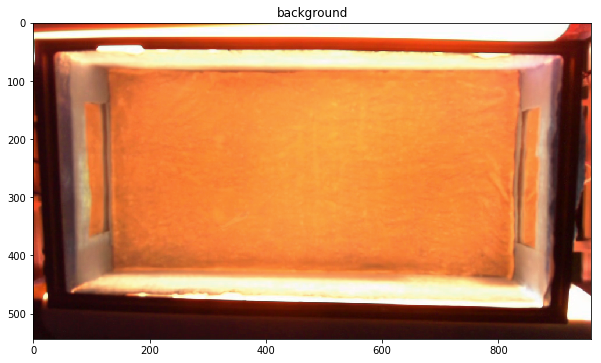

In [7]:
def addToBackgroundImage(frame, old_background_image):
    """add frame to the background image called old_background_image, return updated image."""
    old_background_image = np.float32(old_background_image)
    cv2.accumulateWeighted(frame, old_background_image, 0.05)
    final = cv2.convertScaleAbs(old_background_image)
    return final

# start at the 2000th frame
# cap.set(1, 2000)

background = frame

for i in range(1, number_frames, int(number_frames / 30)):
    print(i)
    cap.set(1, i)
    ret, current_image = cap.read()
    background = addToBackgroundImage(current_image, background)

plt.figure(figsize = (10,10))
plt.imshow(background)
plt.title("background")
plt.show()

Now let's see if we can find the fish by subtracting a random frame from this background image.

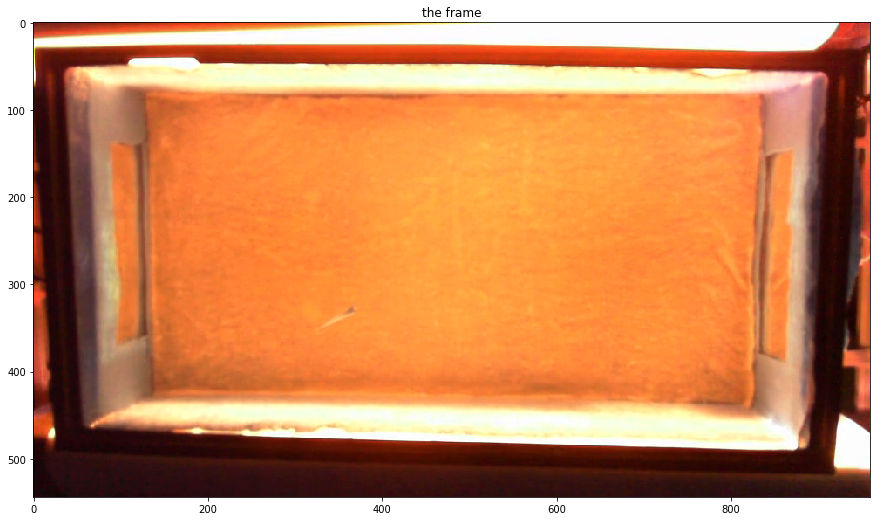

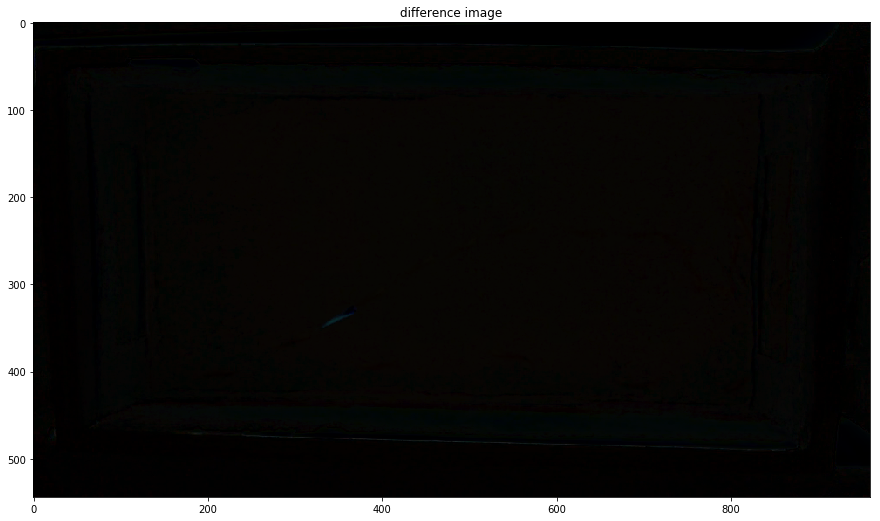

In [7]:
def get_diff_image(frame_number):
    cap.set(1, frame_number)
    _, frame = cap.read()
    diff = cv2.subtract(frame, background)
    return frame, diff

frame, diff = get_diff_image(2000)

plt.figure(figsize = (15,15))
plt.imshow(frame)
plt.title("the frame")
plt.show()

plt.figure(figsize = (15,15))
plt.imshow(diff)
plt.title("difference image")
plt.show()

Huh. Maybe let's select a random collection of frames from the video and see whether we can see the fish in the difference image.

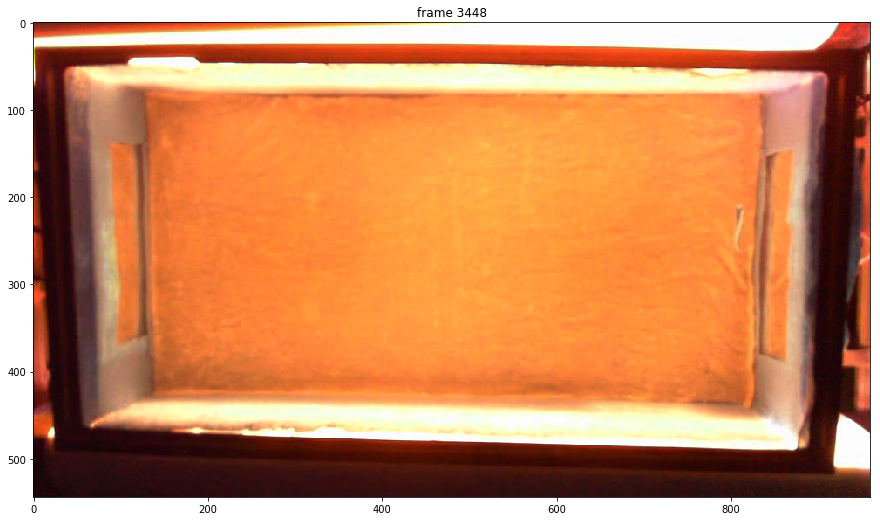

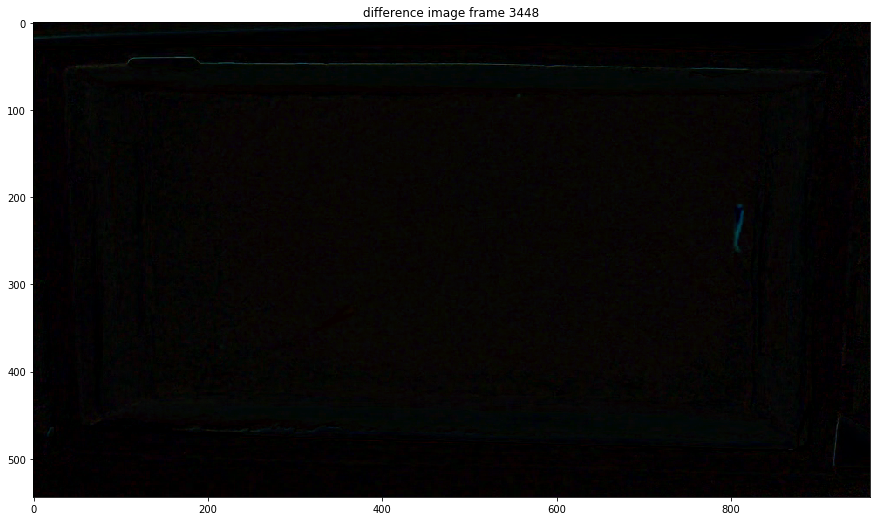

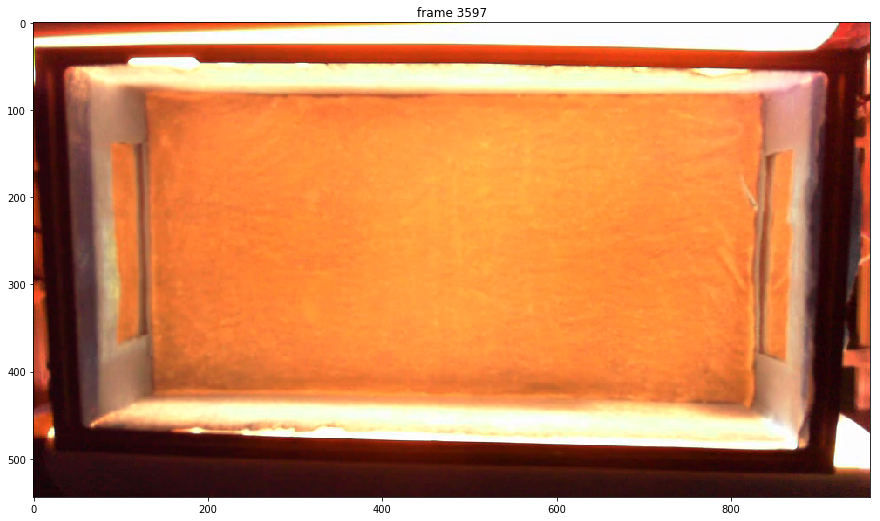

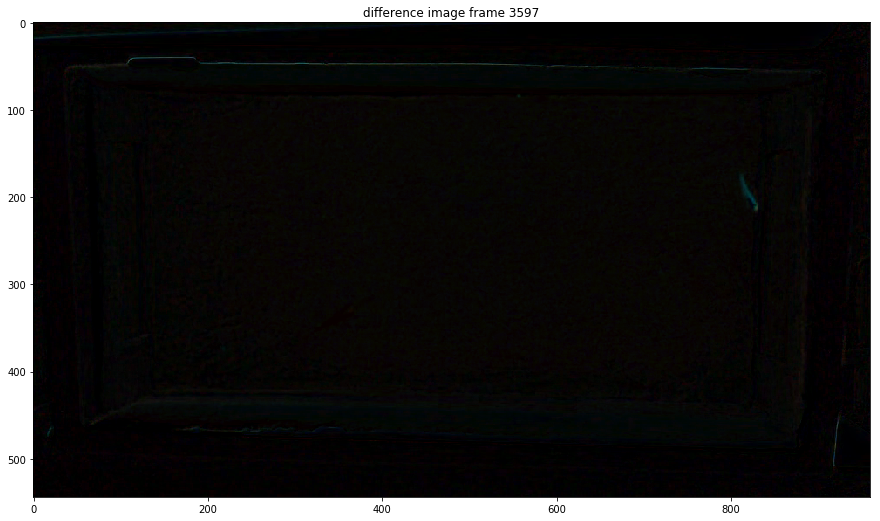

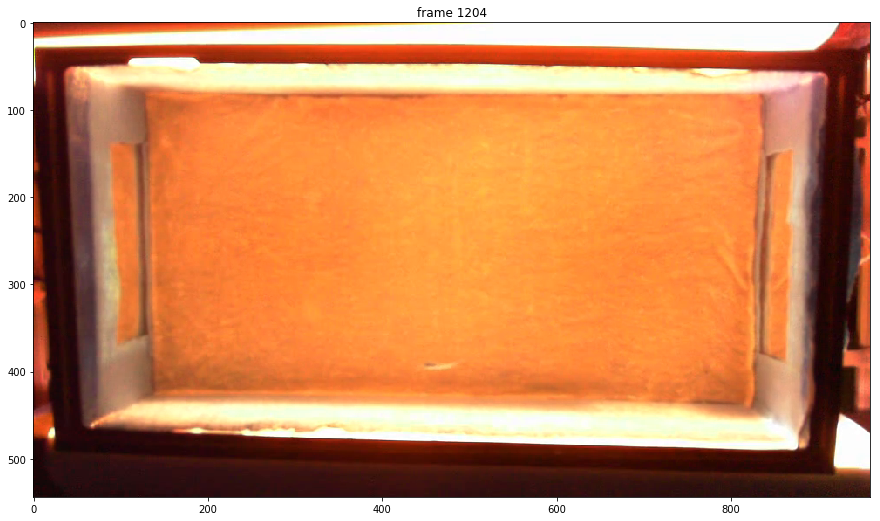

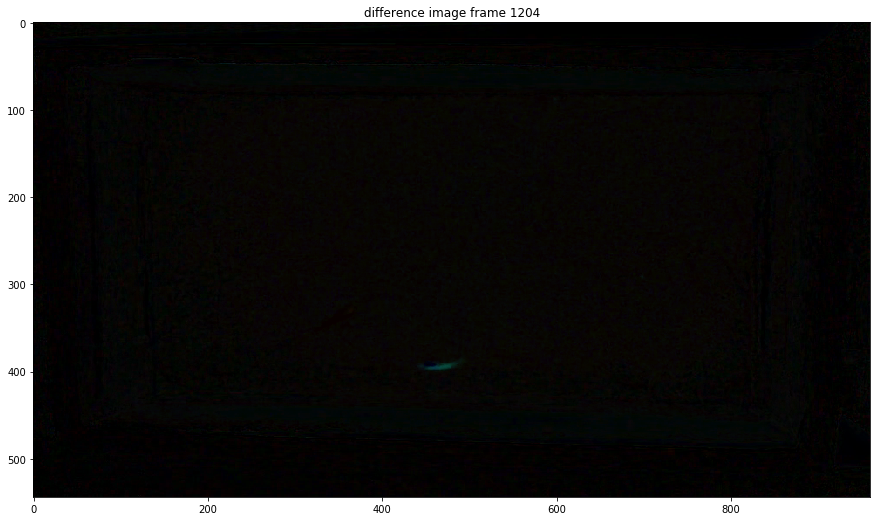

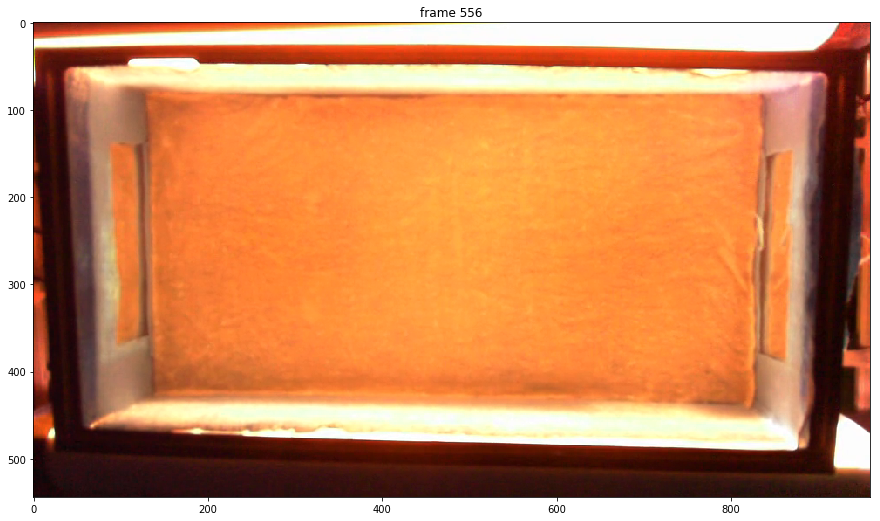

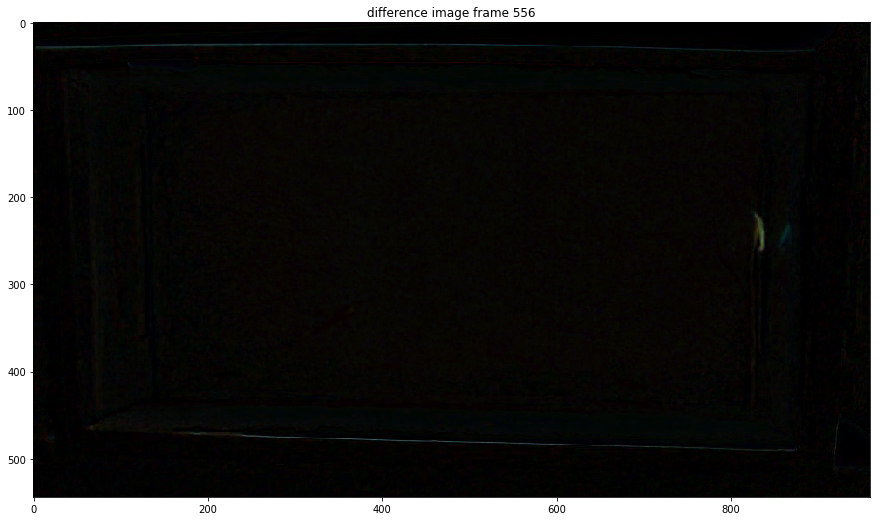

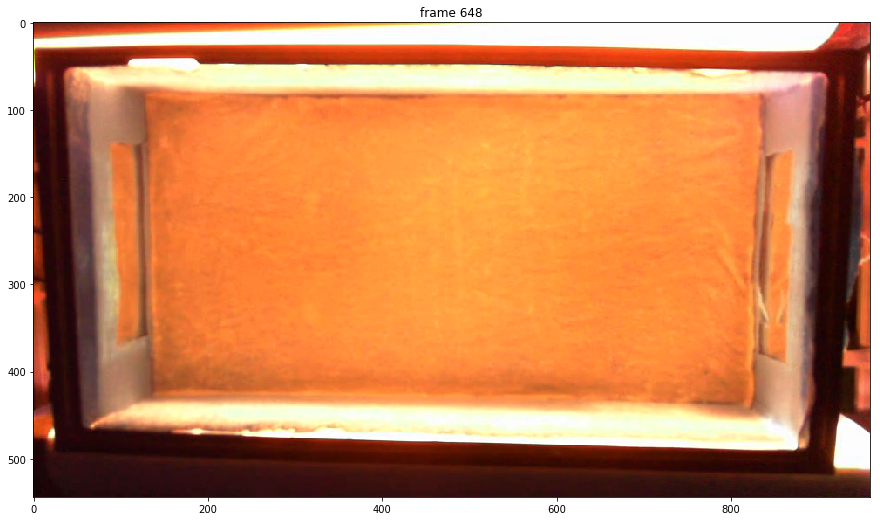

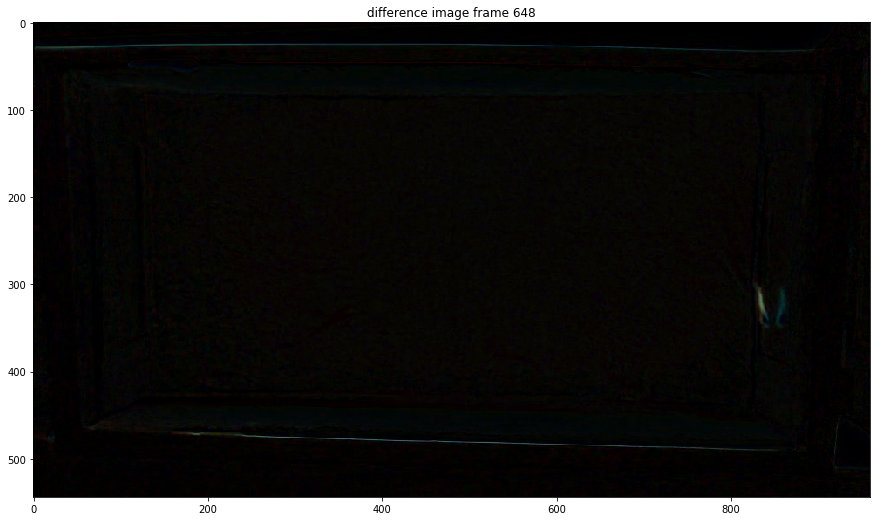

In [8]:
frames = np.random.uniform(1, number_frames, 5)
frames = [int(frame) for frame in frames]

for frame_number in frames:
    frame, diff = get_diff_image(frame_number)
    plt.figure(figsize = (15,15))
    plt.imshow(frame)
    plt.title("frame {}".format(frame_number))
    plt.show()
    
    plt.figure(figsize = (15,15))
    plt.imshow(diff)
    plt.title("difference image frame {}".format(frame_number))
    plt.show()

## things seem to be working now

Using a 1 minute segment of `shuttle_box_lightbluefeltwithfish.wmv` above, I'm about use `cv2.substract` and get something useful in the difference image. The next step is to threshhold and find contours in each of the frames.

I'll start by just messing around and then make some functions later on.

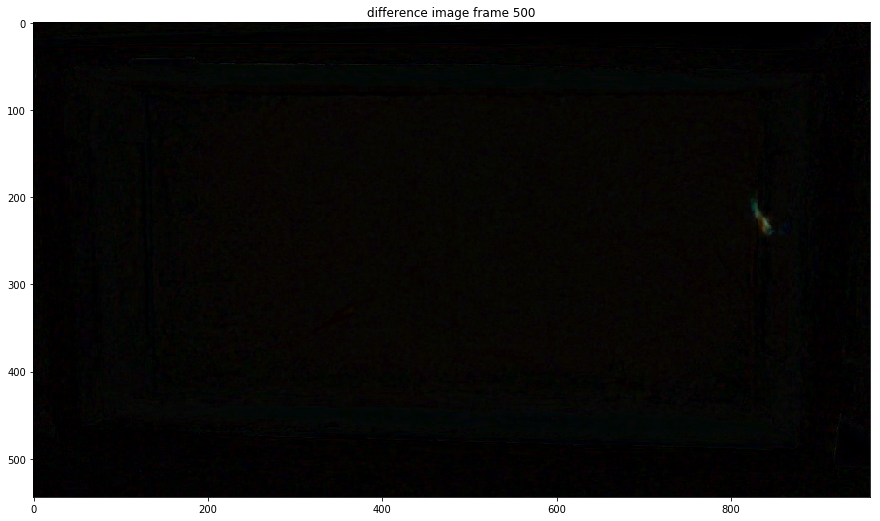

In [9]:
# grab a frame

frame_number = 500

cap.set(1, frame_number)
_, frame = cap.read()
diff = cv2.subtract(frame, background)

plt.figure(figsize = (15,15))
plt.imshow(diff)
plt.title("difference image frame {}".format(frame_number))
plt.show()


Great. We cnan creatly see the fish in this image. Now to blur, convert to grey, and threshold:

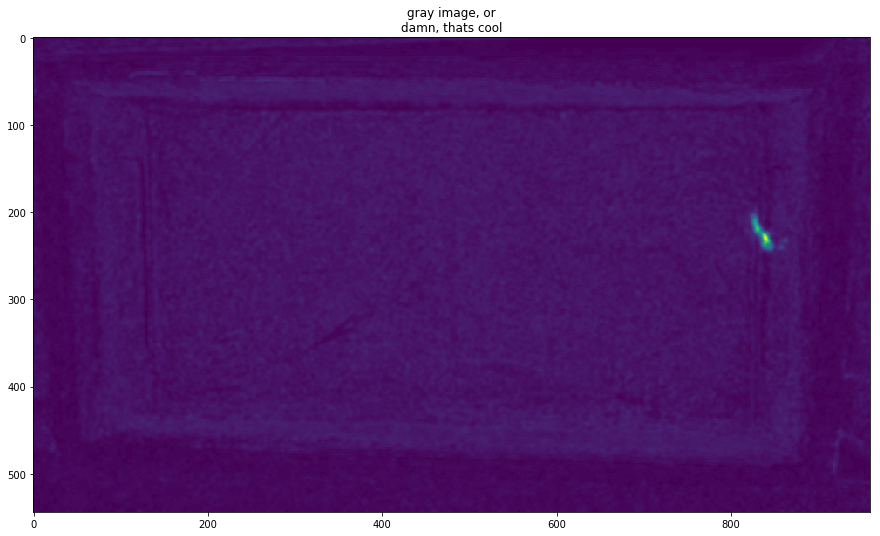

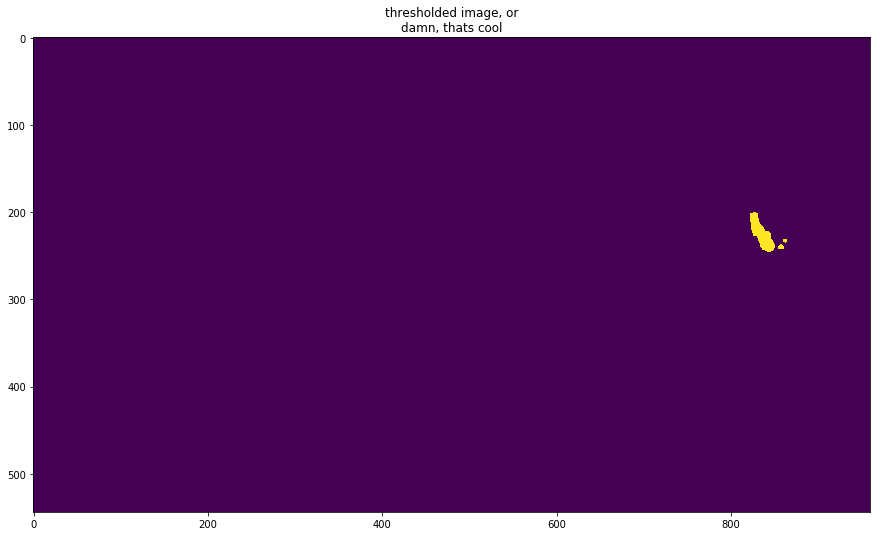

In [10]:
blurred = cv2.blur(diff, (5,5))
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

plt.figure(figsize = (15,15))
plt.imshow(gray)
plt.title("gray image, or\ndamn, thats cool")
plt.show()

plt.figure(figsize = (15,15))
plt.imshow(thresh)
plt.title("thresholded image, or\ndamn, thats cool")
plt.show()


Now we can find contours and take the largest one, and color it in

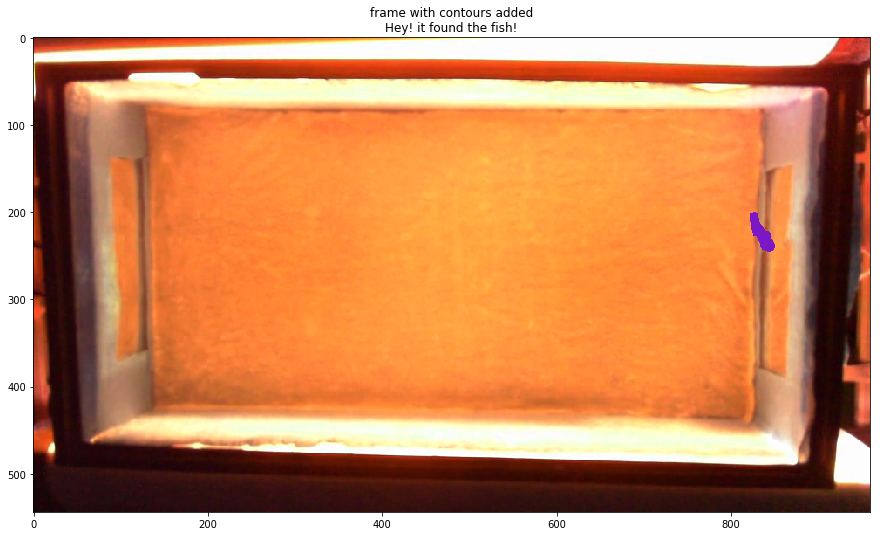

In [11]:
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

# find largest contour. assume fish
c = max(contours, key = cv2.contourArea)

# draw contours
cv2.drawContours(frame,[c],0,(124,23,199),-1)

# show it
plt.figure(figsize = (15,15))
plt.imshow(frame)
plt.title("frame with contours added\nHey! it found the fish!")
plt.show()


Now I'll wrap all of this into a single function call loop though the frames.

In [10]:
def addToBackgroundImage(frame, old_background_image):
    """add frame to the background image called old_background_image, return updated image."""
    old_background_image = np.float32(old_background_image)
    cv2.accumulateWeighted(frame, old_background_image, 0.3)
    final = cv2.convertScaleAbs(old_background_image)
    return final

def get_aspect_ratio(contour):
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = float(w)/h
    return aspect_ratio


font = cv2.FONT_HERSHEY_SIMPLEX
def draw_largest_contour(frame, size_threshold):
    """Returns the frame with the largest contour drawn on it. """
    
    # take difference image, blur, convert to grey, threshold, find contours
    diff = cv2.subtract(frame, background)
    blurred = cv2.blur(diff, (5,5))
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    
    # we now add the step of excluding contours that are too big or too small
    contours_right_size = [c for c in contours if cv2.contourArea(c) < size_threshold and cv2.contourArea(c) > 20]
    
    # we also exclude contours that are too long
    contours_right_size_shape = [c for c in contours if get_aspect_ratio(c) < 10 and get_aspect_ratio(c) > 0.2]
    
    if len(contours_right_size_shape) > 0:
        c = max(contours_right_size_shape, key = cv2.contourArea)
        cv2.drawContours(frame,[c],0,(124,23,199),-1)
        cv2.putText(frame, str(get_aspect_ratio(c)), (50,50), font, 1,(124,23,199),2,cv2.LINE_AA)
    else:
         cv2.putText(frame, str("ain't nobody home!!"), (200,200), font, 4,(124,23,199),2,cv2.LINE_AA)
    return frame


# set up video writer
# this is a useful gist
# https://gist.github.com/takuma7/44f9ecb028ff00e2132e
h, w, _ = frame.shape
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('tracked.avi', fourcc, 60, (w,h), True)

frame_number = 1
cap.set(1, frame_number)

while(frame_number < number_frames):
    _, frame = cap.read()
    
    # update background image every x frames
    if frame_number % 200 ==  0:
        background = addToBackgroundImage(frame, background)
    
    frame = draw_largest_contour(frame)
    out.write(frame)
    frame_number += 1

out.release()

TypeError: draw_largest_contour() missing 1 required positional argument: 'size_threshold'

## next level

At this point the tracker is working okay. One thing we could for sure so it restrict the search for the fish to a smaller area. I attempt this below by defining a circle around the fish and only looking for the fish in a certain radius around this circle.

In [14]:

font = cv2.FONT_HERSHEY_SIMPLEX
def draw_largest_contour(frame, previous_location):
    """Returns the frame with the largest contour drawn on it. """
    
    # take difference image, blur, convert to grey, threshold, find contours
    diff = cv2.subtract(frame, background)
    blurred = cv2.blur(diff, (5,5))
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    
    # at this point, let's restrict our search for the fish
    if previous_location is not None:
        height, width = gray.shape
        circle_img = np.zeros((height, width), np.uint8)
        cv2.circle(circle_img, previous_location, 50, 1, thickness=-1)
        cv2.circle(frame, previous_location, 50, 1, thickness=2)
        masked_data = cv2.bitwise_and(gray, gray, mask=circle_img)
    else:
        masked_data = gray
    
    _, thresh = cv2.threshold(masked_data, 8, 255, cv2.THRESH_BINARY)
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    
    # we now add the step of excluding contours that are too big or too small
    contours_right_size = [c for c in contours if cv2.contourArea(c) < 700 and cv2.contourArea(c) > 20]
    
    # we also exclude contours that are too long
    contours_right_size_shape = [c for c in contours if get_aspect_ratio(c) < 10 and get_aspect_ratio(c) > 0.2]
    
    if len(contours_right_size_shape) > 0:
        c = max(contours_right_size_shape, key = cv2.contourArea)
        cv2.drawContours(frame,[c],0,(124,23,199),-1)
        cv2.putText(frame, str(previous_location), (50,50), font, 1,(124,23,199),2,cv2.LINE_AA)
        M = cv2.moments(c)
        try:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            loc = (cx, cy)
        except:
            loc = previous_location
    else:
        cv2.putText(frame, str("ain't nobody home!!"), (200,200), font, 2,(124,23,199),2,cv2.LINE_AA)
        loc = previous_location
    return frame, loc


# cap.set(1,3000)
# _, frame = cap.read()
# frame = draw_largest_contour(frame)


# plt.figure(figsize = (10,10))
# plt.imshow(frame)
# plt.title("")
# plt.show()

h, w, _ = frame.shape
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('tracked.avi', fourcc, 60, (w,h), True)

frame_number = 1
cap.set(1, frame_number)

# start off with the fish not found
previous_location = None

while(frame_number < 20000):
    _, frame = cap.read()
    
    # update background image every x frames
    if frame_number % 200 ==  0:
        background = addToBackgroundImage(frame, background)
        print("frame {}".format(frame_number))
    
    frame, previous_location = draw_largest_contour(frame, previous_location)
    
#     zeros = np.zeros((h, w), dtype="uint8")
#     frame = cv2.merge([zeros, zeros, frame])
    
    out.write(frame)
    frame_number += 1

out.release()






frame 200
frame 400
frame 600
frame 800
frame 1000
frame 1200
frame 1400
frame 1600
frame 1800
frame 2000
frame 2200
frame 2400
frame 2600
frame 2800
frame 3000
frame 3200
frame 3400
frame 3600
frame 3800
frame 4000
frame 4200
frame 4400
frame 4600
frame 4800
frame 5000
frame 5200
frame 5400
frame 5600
frame 5800
frame 6000
frame 6200
frame 6400
frame 6600
frame 6800
frame 7000
frame 7200
frame 7400
frame 7600
frame 7800
frame 8000
frame 8200
frame 8400
frame 8600
frame 8800
frame 9000
frame 9200
frame 9400
frame 9600
frame 9800
frame 10000
frame 10200
frame 10400
frame 10600
frame 10800
frame 11000
frame 11200
frame 11400
frame 11600
frame 11800
frame 12000
frame 12200
frame 12400
frame 12600
frame 12800
frame 13000
frame 13200
frame 13400
frame 13600
frame 13800
frame 14000
frame 14200
frame 14400
frame 14600
frame 14800
frame 15000
frame 15200
frame 15400
frame 15600
frame 15800
frame 16000
frame 16200
frame 16400
frame 16600
frame 16800
frame 17000
frame 17200
frame 17400
frame 176

Next steps: be more strict with contour filtering if you haven't found the fish.
Downside of this approach is that the tracker might get stuck on some spots on the side of the tank
Could fix that by hand-coding the tank boundaries and excluding contours nearby.